# Predicting the Margin of NFL Games using linear regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from clean3 import clean_games

In [2]:
# gather & pre-process our data (for details, see clean_game_data.ipynb and clean3.py)
df = clean_games('data/games.pickle', start_year=1990)

In [56]:
game_df = df.copy() # to prevent needing to rerun clean_games

## Feature Selection

See `feature_engineering.ipynb` for more information about the feature selection process.

In [57]:
features = [
    'season_year',
    'team_home_game',
    'ewma_team_home_game',
    'ewma10_margin',
    'ewma10_wins_opp',
    'roll19_wins',
    'roll19_margin_opp',
    'ewma_margin_opp',
    'ewma_margin',
    'ewma_pass_yds_def',
    'ewma_total_yds_def',
    'ewma_total_yds_def_opp',
    'ewma_result_win_opp',
    'ewma_third_conv_pct',
    'ewma_third_conv_pct_opp',
    'ewma_pass_cmp_def',
    'ewma_pass_cmp_perc_def', 
    'ewma_pass_cmp_perc_def_opp', 
    'ewma4_margin_opp',
]

target = 'margin'

print("Number of Features: ", len(features))

Number of Features:  19


In [58]:
all_cols = [c for c in features]
all_cols.append('margin')
model_df = game_df[all_cols]

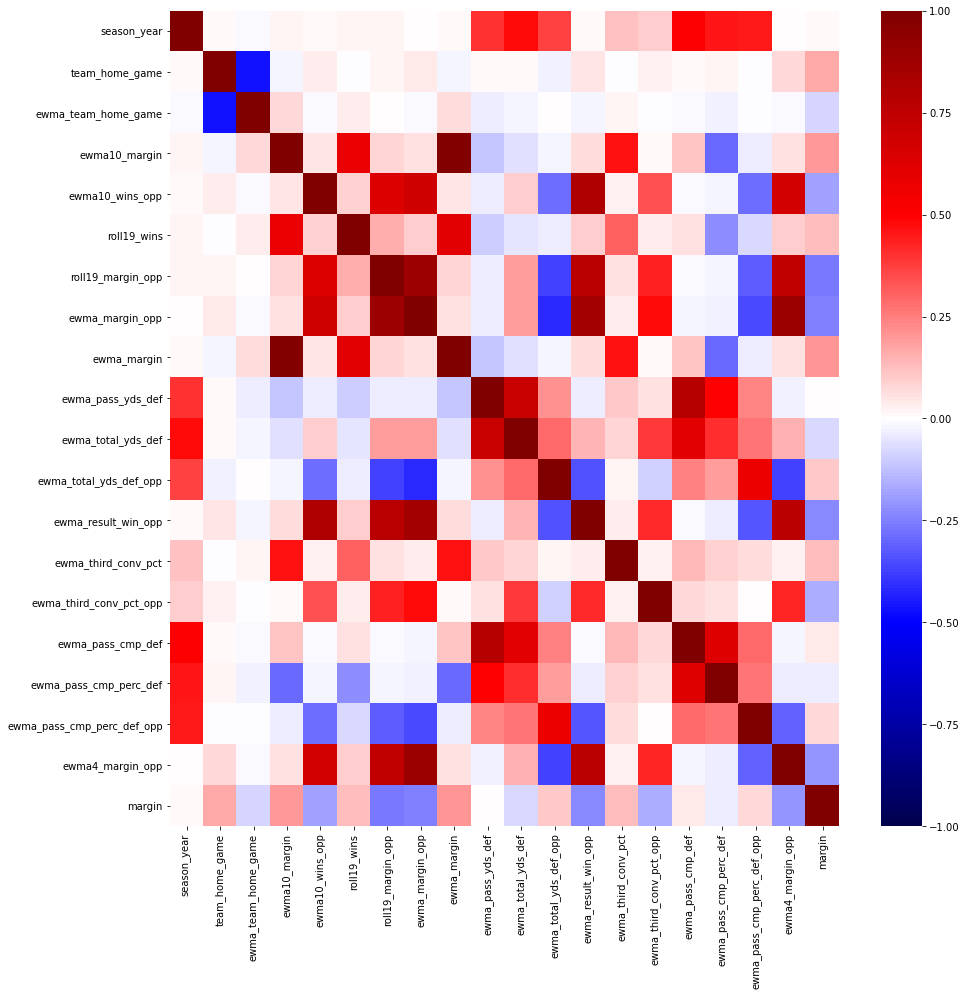

In [59]:

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(game_df[all_cols].corr(), cmap="seismic", vmin=-1, vmax=1, ax=ax);

In [60]:
game_df.reindex()

,game_id,season_year,week_num,team_year,full_game_date,team,decade,opp,game_day_of_week,game_outcome,...,ewma_to_def_opp,log_year,ewma_third_conv_pct,ewma_third_conv_pct_def,ewma_third_conv_pct_opp,ewma_third_conv_pct_def_opp,ewma_total_yds_off,ewma_total_yds_def,ewma_total_yds_off_opp,ewma_total_yds_def_opp
12,atl-rai-1991-09-22,1991,4.0,atl-1991,1991-09-22,atl,199,rai,Sun,W,...,1.285834,7.596392,0.414545,0.236831,0.444372,0.384148,196.465,311.192,275.041,317.376
16,atl-nor-1991-09-29,1991,5.0,atl-1991,1991-09-29,atl,199,nor,Sun,L,...,2.062954,7.596392,0.415208,0.267617,0.323996,0.201953,209.705,302.268,299.874,213.147
20,atl-sfo-1991-10-13,1991,7.0,atl-1991,1991-10-13,atl,199,sfo,Sun,W,...,1.467015,7.596392,0.366330,0.333438,0.406125,0.399926,189.997,392.980,368.613,283.708
24,atl-crd-1991-10-20,1991,8.0,atl-1991,1991-10-20,atl,199,crd,Sun,L,...,1.939072,7.596392,0.383877,0.390719,0.391666,0.405214,194.481,390.020,288.207,332.186
28,atl-ram-1991-10-27,1991,9.0,atl-1991,1991-10-27,atl,199,ram,Sun,W,...,1.766791,7.596392,0.359075,0.395877,0.382289,0.348152,197.839,367.537,279.497,325.905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56488,sea-sfo-2020-11-01,2020,8.0,sea-2020,2020-11-01,sea,202,sfo,Sun,W,...,1.575977,7.610853,0.334001,0.480642,0.433014,0.344198,300.811,606.242,386.013,306.406
56516,sea-was-2020-12-20,2020,15.0,sea-2020,2020-12-20,sea,202,was,Sun,W,...,1.359437,7.610853,0.407098,0.447129,0.357849,0.356448,257.488,469.465,316.120,310.254
56524,sea-sfo-2021-01-03,2020,17.0,sea-2020,2021-01-03,sea,202,sfo,Sun,W,...,1.866593,7.610853,0.419085,0.470560,0.372161,0.338475,234.641,505.893,376.277,315.867
56574,sfo-was-2020-12-13,2020,14.0,sfo-2020,2020-12-13,sfo,202,was,Sun,L,...,1.182742,7.610853,0.407858,0.375742,0.384705,0.372204,262.378,457.983,335.184,305.029


In [61]:
X = model_df[features]
y = game_df[target]

## Rigorous Cross-Validation Using Manual K-Fold

I will be using an 80/20 Train/Test split. Note that despite all of the cross-validation we completed in `feature_selection.ipynb`, we still have yet to predict `y_test` using `X_test` data.

The reason we haven't yet used our test set is to prevent overfitting. By holding these out and engineering the features we're including in our model, we should avoid **overfitting**. This would result in our model recognizing outliers as patterns and ultimately the inability to generalize to fresh inputs.

In [62]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, lars_path
from sklearn.metrics import mean_squared_error, mean_absolute_error

def cross_validate_lr(X, y):
    '''
        Performs K-Fold cross-validation on linear regression model and computes model metrics

        Features are scaled using standard scaler.

        ------------------
        Parameters:

        - X: DataFrame or numpy array of features/independent variables from training set
        - y: DataFrame or numpy array of target/dependent variable from training set

        ------------------
        Returns:
        
        - model

        Model metrics with cross-validation: R^2 score for training and validation sets
        with each fold, mean R^2 score for validation set across all folds;
        mean training/validation score ratios, MAE, RMSE across all folds
    '''
    
    train_results = []
    val_results = []
    ratios = []
    maes = []
    rmses = []
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)   # default values
    
    
    for train_ind, val_ind in kf.split(X_train_val, y_train_val):
        
        
        # iterate thru 5 shuffled train/validation sets & collect results
        X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
        X_val, y_val = X.iloc[val_ind], y.iloc[val_ind]
        
        # standardize data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train.values)
        X_val_scaled = scaler.transform(X_val.values)
        X_test_scaled = scaler.transform(X_test.values) # scaling test set now
        
        # fit linear model to the standardized train dataset
        model = LinearRegression()
        model.fit(X_train_scaled, y_train)
        
        # validate
        y_pred = model.predict(X_val)
        
        # store results
        train_results.append(model.score(X_train_scaled, y_train))
        val_results.append(model.score(X_val_scaled, y_val))
        ratios.append(model.score(X_train_scaled, y_train) / model.score(X_val_scaled, y_val))
        maes.append(mean_absolute_error(y_val, y_pred))
        rmses.append(np.sqrt(mean_squared_error(y_val, y_pred)))
        
    # summarize results    
    print('Linear regression train R^2:', train_results)
    print('-----------')
    print('Linear regression val R^2: \n ', val_results)
    print('-----------')
    print(f'Linear regression mean val R^2: {np.mean(val_results):.3f} +- {np.std(val_results):.3f}')
    print('-----------')
    print(f'Mean train/val R^2 ratio: {np.mean(ratios):.3f} +- {np.std(ratios):.3f}')
    print('-----------')
    print('Mean MAE: ', np.mean(maes))
    print('-----------')
    print('Mean RMSE: ', np.mean(rmses))
    
    return model, X_test_scaled, y_test, scaler

## Testing Results

In [63]:
model, X_test_scaled, y_test, scaler = cross_validate_lr(X, y)

Linear regression train R^2: [0.16603781810820528, 0.1606730523999419, 0.169757759313373, 0.16572253537969395, 0.16617404764363142]
-----------
Linear regression val R^2: 
  [0.15506443779589252, 0.17537005437469577, 0.1381652520377401, 0.15722800352147592, 0.15050269215490442]
-----------
Linear regression mean val R^2: 0.155 +- 0.012
-----------
Mean train/val R^2 ratio: 1.075 +- 0.100
-----------
Mean MAE:  363.65431930484664
-----------
Mean RMSE:  408.49420142190957


In [64]:
model.score(X_test_scaled, y_test)

0.1428633368352068

Not bad! The model generalized fairly well - less than 0.15 lower than our mean cross-validation $R^2$.

Let's take a look at our features and their corresponding slopes/coefficients

In [65]:
for feature, coef in zip(features, model.coef_):
    print(feature, ': ', coef)

season_year :  -0.11851926531776102
team_home_game :  2.6795437645241607
ewma_team_home_game :  -0.1877000125547824
ewma10_margin :  -1.8491736749707641
ewma10_wins_opp :  0.2309458755730581
roll19_wins :  0.2547303310064057
roll19_margin_opp :  -2.767580755447202
ewma_margin_opp :  0.004295074341594877
ewma_margin :  4.966457558397433
ewma_pass_yds_def :  0.9239033048824546
ewma_total_yds_def :  -0.8549262021315621
ewma_total_yds_def_opp :  0.3328430397920709
ewma_result_win_opp :  -1.0059291901300147
ewma_third_conv_pct :  0.602566770863163
ewma_third_conv_pct_opp :  -0.38186616665731893
ewma_pass_cmp_def :  -0.058901973713604845
ewma_pass_cmp_perc_def :  -0.0693075835179359
ewma_pass_cmp_perc_def_opp :  -0.4252033606773433
ewma4_margin_opp :  -0.5245631453779568


In [66]:
model.coef_

array([-1.18519265e-01,  2.67954376e+00, -1.87700013e-01, -1.84917367e+00,
        2.30945876e-01,  2.54730331e-01, -2.76758076e+00,  4.29507434e-03,
        4.96645756e+00,  9.23903305e-01, -8.54926202e-01,  3.32843040e-01,
       -1.00592919e+00,  6.02566771e-01, -3.81866167e-01, -5.89019737e-02,
       -6.93075835e-02, -4.25203361e-01, -5.24563145e-01])

## Plotting Results

In [71]:
y_test.shape, test_df.shape

((1195,), (1195, 22))

In [72]:
model
test_df = pd.DataFrame(X_test_scaled)
test_df.columns = features

# test_features = test_df[features].to_numpy()

predictions = model.predict(test_features)
test_df['prediction'] = predictions



test_df['actual'] = list(y_test)
test_df['resid'] = test_df['prediction'] - test_df['actual']
test_df

,season_year,team_home_game,ewma_team_home_game,ewma10_margin,ewma10_wins_opp,roll19_wins,roll19_margin_opp,ewma_margin_opp,ewma_margin,ewma_pass_yds_def,...,ewma_result_win_opp,ewma_third_conv_pct,ewma_third_conv_pct_opp,ewma_pass_cmp_def,ewma_pass_cmp_perc_def,ewma_pass_cmp_perc_def_opp,ewma4_margin_opp,prediction,actual,resid
0,1.268250,1.008146,-0.903879,-0.409130,0.951202,-0.238348,1.843435,1.889783,-0.358871,0.908438,...,1.076219,-0.483452,2.662976,0.758113,-0.218256,1.095562,2.419386,-8.104778,-7.0,-1.104778
1,2.394175,1.008146,0.164716,0.773584,0.951202,0.750141,0.226077,0.063337,0.851558,0.065893,...,0.595497,-0.146089,0.787407,0.431094,1.056019,1.582467,-0.182206,3.120066,-19.0,22.120066
2,-0.702119,-0.991920,0.196457,-1.066193,-1.051301,-0.897340,-0.775145,-0.889853,-1.076616,-0.479123,...,-0.863989,-1.397891,-0.412325,-0.181388,-0.241806,-0.122854,-0.860882,-4.116294,2.0,-6.116294
3,0.705287,-0.991920,0.228197,1.036409,-1.051301,1.738630,-0.667321,-0.561647,0.814297,-0.628618,...,-0.708080,1.961055,0.086443,0.537692,1.851798,0.232307,-0.634657,2.405633,7.0,-4.594367
4,1.690472,-0.991920,-0.734597,-1.197606,-1.051301,0.420645,-0.559497,0.083696,-0.724135,0.518378,...,-0.339960,0.734998,-0.119972,0.596230,1.487200,0.949134,1.401372,-3.801240,6.0,-9.801240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1190,-1.124341,1.008146,-1.411727,-1.197606,-1.051301,-1.226837,-0.066588,-0.149136,-1.082871,-0.196574,...,-0.920290,0.605297,1.328728,-0.019505,-0.114421,0.435796,-0.521544,-0.211590,8.0,-8.211590
1191,0.705287,1.008146,0.778366,-0.014892,0.951202,1.738630,2.136099,1.114633,-0.130683,0.683360,...,1.279767,0.792900,0.586851,0.673919,0.419524,-1.401897,1.062034,-5.431648,-4.0,-1.431648
1192,-0.420638,-0.991920,-0.300810,-1.197606,0.951202,-0.897340,0.549548,0.933177,-1.128971,-0.826483,...,0.305332,-0.718629,0.016278,-1.085839,-1.445644,-0.948977,0.609583,-9.709347,-34.0,24.290653
1193,0.001584,-0.991920,1.064030,1.299235,0.951202,0.420645,0.796003,1.082387,1.469760,-0.910779,...,0.928971,0.495058,0.527250,-0.144170,1.132022,0.326080,0.948921,-2.004834,6.0,-8.004834


<AxesSubplot:xlabel='prediction', ylabel='actual'>

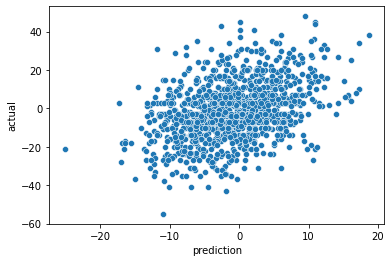

In [74]:
sns.scatterplot(x=test_df.prediction, y=test_df.actual)

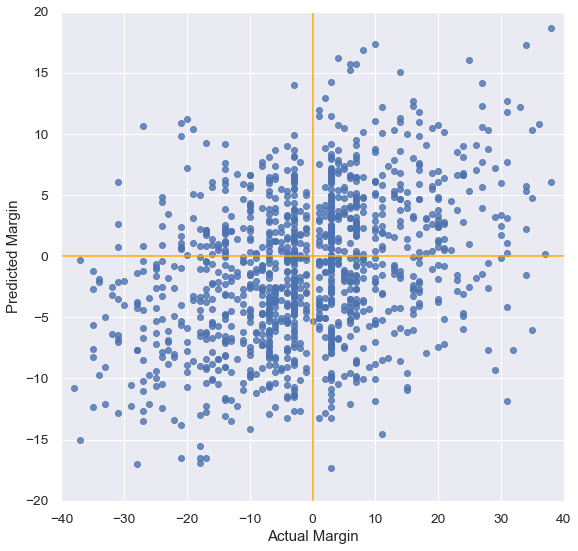

In [116]:
sns.set(rc={'figure.figsize':(9, 9)}, font_scale=1.25)
fig, ax = plt.subplots()
ax.scatter(test_df['actual'], test_df['prediction'], alpha=0.8)
ax.set_xlabel('Actual Margin')
ax.set_ylabel('Predicted Margin')
ax.set_title("A")
plt.axvline(x=0, color='orange')
plt.axhline(y=0, color='orange')
plt.xlim((-40, 40))
plt.ylim((-20, 20))
plt.show()

Add to above plot:
- 4 quadrants
- title
- bigger labels
- different style

In [121]:
test_df['predicted_wl'] = (test_df.prediction > 0) & (test_df.actual > 0)

test_df['predicted_wl']


0       False
1       False
2       False
3        True
4       False
        ...  
1190    False
1191    False
1192    False
1193    False
1194     True
Name: predicted_winner, Length: 1195, dtype: bool